In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import time
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_path(cart_path,target,xlim=[-5,5],ylim=[-5,5]):
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.xlim(xlim[0],xlim[1])
    plt.ylim(ylim[0],ylim[1])
    plt.grid()
    plt.show()

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


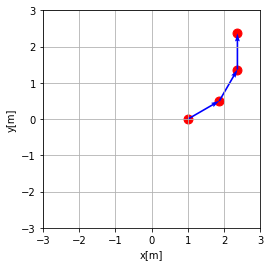

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes,[-3,3],[-3,3])

In [5]:
# dataset
DATA_SIZE = 1000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_SPACE = 0.05 # [m / step]
X_train = []
for i in range(DATA_SIZE):
    d = data.make_arc_path_2(int(DATA_NUM_WAYPOINTS*DATA_SPACE+1),xp.random.rand()*(2*xp.pi/2)-xp.pi/2) # -90 ~ 90 deg
    d_es,_ = data.get_evenly_spaced_points(d,DATA_SPACE)
    d_xy = d_es[0:DATA_NUM_WAYPOINTS]
    #d_xy_fl = xp.ravel(d_xy[0:DATA_WAYPOINTS])
    X_train.append(d_xy)
print(len(X_train))
print(X_train[0])

1000
[[ 4.08053023e-02  8.21477638e-04 -1.53053849e+00]
 [ 1.01868636e-01  5.13059572e-03 -1.47015172e+00]
 [ 1.62560612e-01  1.31170358e-02 -1.40976496e+00]
 [ 2.22659981e-01  2.47516836e-02 -1.34937820e+00]
 [ 2.81947654e-01  3.99921257e-02 -1.28899144e+00]
 [ 3.40207500e-01  5.87828037e-02 -1.22860468e+00]
 [ 3.97227135e-01  8.10552170e-02 -1.16821792e+00]
 [ 4.52798698e-01  1.06728173e-01 -1.10783115e+00]
 [ 5.06719604e-01  1.35708081e-01 -1.04744439e+00]
 [ 5.58793288e-01  1.67889297e-01 -9.87057631e-01]]


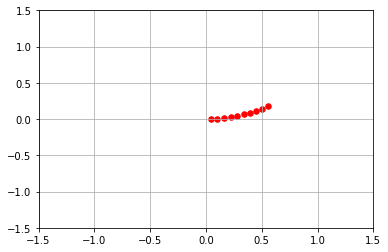

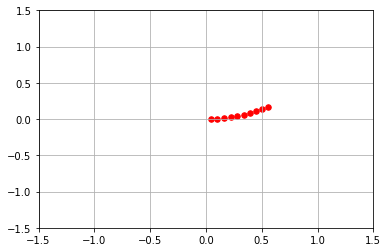

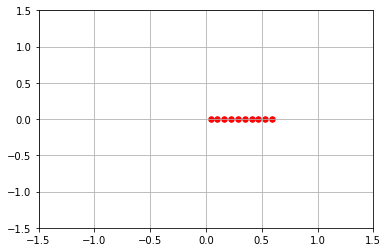

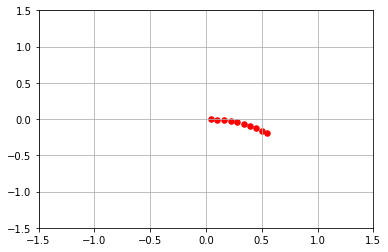

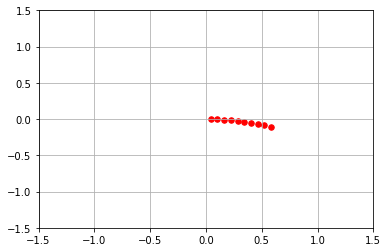

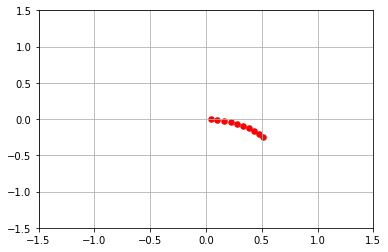

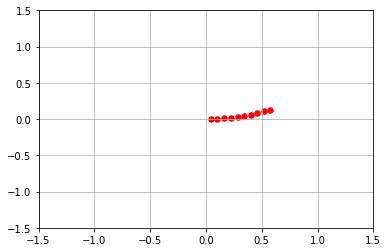

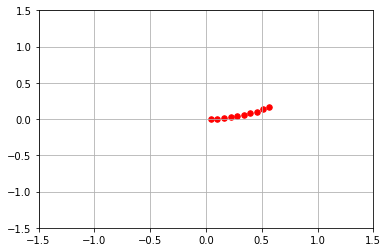

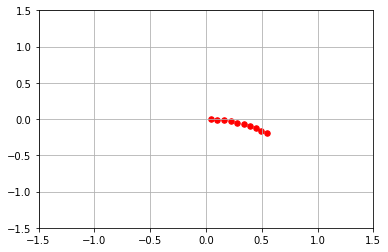

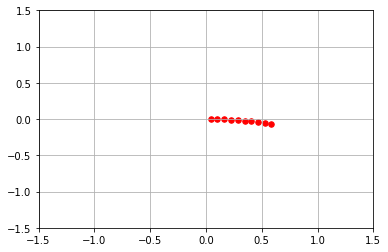

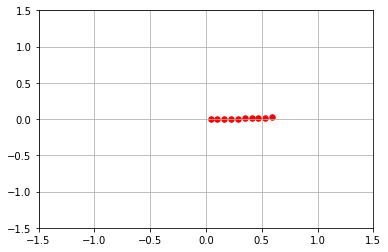

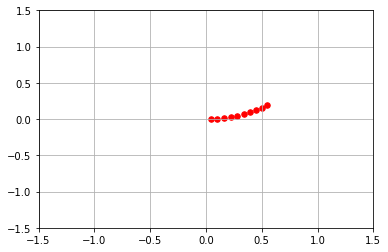

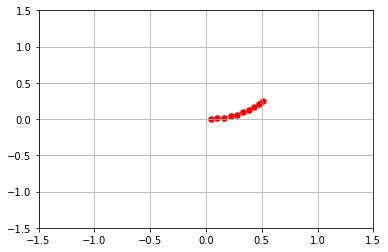

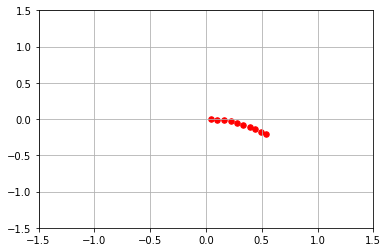

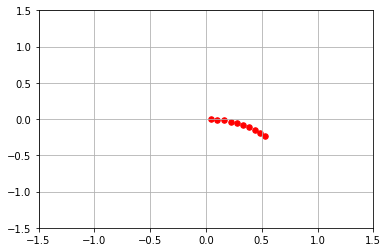

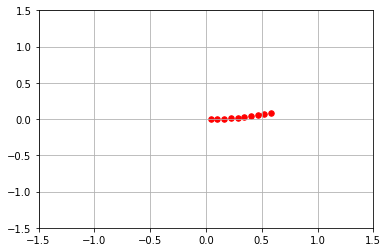

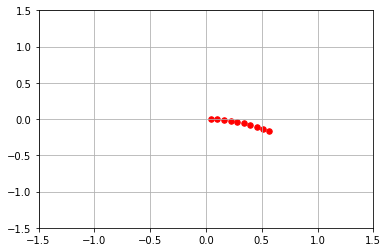

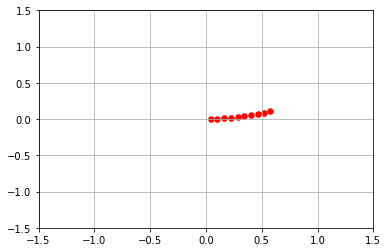

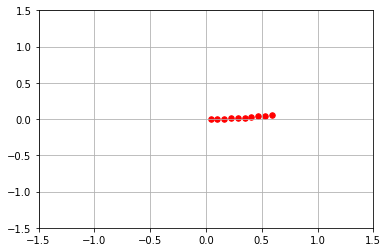

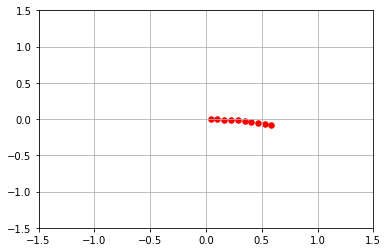

In [6]:
# plot data
p = X_train
if(settings.gpu_index >= 0):
    p = xp.asnumpy(p)

for num in range(20):
    rand_idx = int(np.random.rand() * len(X_train))
    plt.scatter(p[rand_idx][:,0], p[rand_idx][:,1],c="red",edgecolor="red",s=30,marker="o")
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.grid()
    plt.show()

In [7]:
# loss
def error_squares(predict,groundtruth):
    #print(predict)
    #print(groundtruth)
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = groundtruth * w
    p = predict * w
    error = F.sqrt(F.sum((t-p)*(t-p)))
    return error

In [8]:
# training
def train(model,X,epoch=10):
    if settings.gpu_index >= 0:
        cuda.cupy.cuda.Device(settings.gpu_index).use()
        model.to_gpu(settings.gpu_index)
    opt = optimizers.Adam()
    opt.setup(model)
    ep = 0
    AvgE = []
    while ep < epoch:
        random.shuffle(X)
        E = .0
        for itr in range(len(X)):
            x = xp.ravel(X[itr][:,0:2])
            x = Variable(xp.array([x],dtype=xp.float32))
            y = model(x)
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
            y_pad = F.concat((y,pad),axis=2)
            y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
            
            # loss
            z_true = X[itr][:]
            z = y_pad[0,0]
            e = error_squares(z,z_true[0])
            #model.cleargrads()
            #e.backward()
            #opt.update()
            for step in range(1,DATA_NUM_STEP):
                z = oplus(z,y_pad[0,step])
                e = e + error_squares(z,z_true[step])
            model.cleargrads()
            e.backward()
            opt.update()
            E = E + e.data
        ep = ep + 1
        print('Epoch:',ep,', Average loss:',E / len(X))
        AvgE.append(E / len(X))
    plt.plot(range(len(AvgE)),AvgE)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss')
    return model

Epoch: 1 , Average loss: 0.5484763
Epoch: 2 , Average loss: 0.12074887
Epoch: 3 , Average loss: 0.07409631
Epoch: 4 , Average loss: 0.06323228
Epoch: 5 , Average loss: 0.050247718
Epoch: 6 , Average loss: 0.04189406
Epoch: 7 , Average loss: 0.03212864
Epoch: 8 , Average loss: 0.027571416
Epoch: 9 , Average loss: 0.022920845
Epoch: 10 , Average loss: 0.018604714
Epoch: 11 , Average loss: 0.018141074
Epoch: 12 , Average loss: 0.019526323
Epoch: 13 , Average loss: 0.021257335
Epoch: 14 , Average loss: 0.018963814
Epoch: 15 , Average loss: 0.016288182
Epoch: 16 , Average loss: 0.017904984
Epoch: 17 , Average loss: 0.017472697
Epoch: 18 , Average loss: 0.019331075
Epoch: 19 , Average loss: 0.018001346
Epoch: 20 , Average loss: 0.01765197
Epoch: 21 , Average loss: 0.020664658
Epoch: 22 , Average loss: 0.01835541
Epoch: 23 , Average loss: 0.018467316
Epoch: 24 , Average loss: 0.017816463
Epoch: 25 , Average loss: 0.017185971
Epoch: 26 , Average loss: 0.016995935
Epoch: 27 , Average loss: 0.01

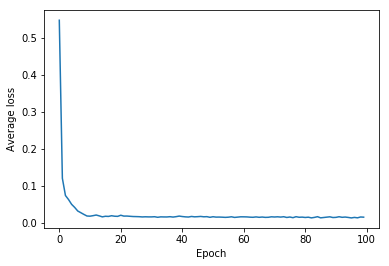

In [9]:
EPOCH = 100
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_STEP)
model = train(model,X_train,epoch=EPOCH)
print('finished')

 --- input --- 
[[ 4.08157592e-02  1.86363583e-04 -1.56166445e+00]
 [ 1.02031953e-01  1.16472990e-03 -1.54796663e+00]
 [ 1.63229002e-01  2.98150652e-03 -1.53426881e+00]
 [ 2.24395425e-01  5.63635257e-03 -1.52057099e+00]
 [ 2.85519746e-01  9.12876992e-03 -1.50687317e+00]
 [ 3.46590495e-01  1.34581033e-02 -1.49317535e+00]
 [ 4.07596215e-01  1.86235404e-02 -1.47947754e+00]
 [ 4.68525458e-01  2.46241121e-02 -1.46577972e+00]
 [ 5.29366793e-01  3.14586925e-02 -1.45208190e+00]
 [ 5.90108804e-01  3.91259991e-02 -1.43838408e+00]]
 --- output --- 
[[[0.04071508 0.         0.01928522]
  [0.06128373 0.         0.01008174]
  [0.06135919 0.         0.01404679]
  [0.06114915 0.         0.01355036]
  [0.0610352  0.         0.01431479]
  [0.06112223 0.         0.01316316]
  [0.06124641 0.         0.01509759]
  [0.06111556 0.         0.01266604]
  [0.06126836 0.         0.01345824]
  [0.06119832 0.         0.04785059]]]
 --- error --- 
loss: variable(0.00021182)
loss: variable(4.770461e-05)
loss: variab

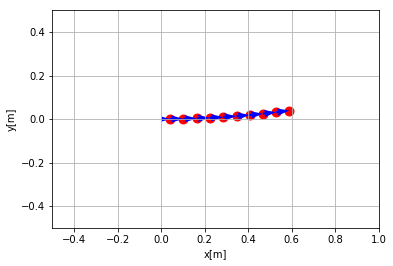

In [14]:
x_path = data.make_arc_path_2(int(DATA_NUM_WAYPOINTS*DATA_SPACE+1),xp.random.rand()*(2*xp.pi/2)-xp.pi/2)
x_path_es,_ = data.get_evenly_spaced_points(x_path,DATA_SPACE)
x_test = x_path_es[0:DATA_NUM_WAYPOINTS]
x = xp.ravel(x_test[:,0:2])
x = Variable(xp.array([x],dtype=xp.float32))
y = model(x)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
y_pad = F.concat((y,pad),axis=2)
y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
print(' --- input --- ')
print(x_test)
print(' --- output --- ')
print(y_pad.data)
# loss
z_true = x_test
z = y_pad[0,0]
e = error_squares(z,z_true[0])
print(' --- error --- ')
print('loss:',e)
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    e = error_squares(z,z_true[step])
    print('loss:',e)
    Z = xp.vstack((Z,z.data))
print(' --- trajectory --- ')
print(Z)
print(z_true.shape)
plot_path(Z,z_true,[-.5,1],[-.5,.5])

In [11]:
import datetime
def gen_filename():
    name_date = '{0:%Y%m%d%H%M%S}'.format(datetime.datetime.now())
    name_epoch = '{}epoch'.format(EPOCH)
    name_datasize  = '{}data'.format(DATA_SIZE)
    name_num_step = '{}step'.format(DATA_NUM_WAYPOINTS)
    name_space = '{}mm'.format(int(DATA_SPACE * 1000))
    model_name = 'Cart' + name_space + name_num_step + '_' + name_date + '_'   + name_datasize + name_epoch + '.model'
    print(model_name)
    return model_name

fn = gen_filename()
serializers.save_npz(fn, model)

Cart50mm10step_20190820052845_1000data100epoch.model
